In [22]:
%pip install huggingface-hub
%pip install numpy
%pip install opencv-python
%pip install matplotlib
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import

In [3]:
import os
import json
import re
import time
import math
import numpy as np
import numpy

In [4]:
import cv2
import matplotlib.pyplot as plt

## Config

In [5]:
# secret_hf = 

In [6]:
# !huggingface-cli login --token $secret_hf

## Download data

In [7]:
!mkdir dataset

In [8]:
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="hotamago/Hoc-sau-va-ung-dung-nhom-2", filename="imagedata.zip", revision="main", repo_type="dataset", local_dir="dataset", local_dir_use_symlinks=False)
hf_hub_download(repo_id="hotamago/Hoc-sau-va-ung-dung-nhom-2", filename="label.txt", revision="main", repo_type="dataset", local_dir="dataset", local_dir_use_symlinks=False)

imagedata.zip:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

label.txt:   0%|          | 0.00/48.9k [00:00<?, ?B/s]

'dataset/label.txt'

In [9]:
!sudo apt-get install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1.2).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [10]:
!mkdir datasetImage
!unzip -q -o "dataset/imagedata.zip" -d "datasetImage"

## Load data

In [11]:
rawlabel = ""

In [12]:
# load label
with open("/kaggle/working/dataset/label.txt", "r") as f:
    rawlabel = f.read()
    
# G93aRj07CIZPKaC8.jpg {"label-8":14,"label-7":3,"label-2":4} 16
# name image, label(json), totel people vote
# Format to json {name, label, totel}
labelDataset = []
arrayRawLabel = rawlabel.split("\n")
for ele in arrayRawLabel:
    eleArr = ele.split(" ")
    try:
        labelDataset.append({
            "name": eleArr[0],
            "label": json.loads(eleArr[1]),
            "total": int(eleArr[2])
        })
    except:
        print(ele)

In [13]:
# Label 0 -> 10, 0 is not good image need to delete
def LabelsToVector(labels):
    vectorLabel = [0] * 11
    for label, num in labels.items():
        if len(label.split("-")) != 2:
            print("Error: ", labels)
        vectorLabel[int(label.split("-")[1])] = num
    return vectorLabel

def NormalVectorLabel(vectorLabel, total, presentFilter):
    # Check if label 0 is > presentFilter
    if vectorLabel[0]/total > presentFilter:
        vectorLabel[0] = 1
        for i in range(1, len(vectorLabel)):
            vectorLabel[i] = 0
        return np.array(vectorLabel)
    
    # Process localcation label
    totalLocalVote = 0
    for i in range(1, 3):
        totalLocalVote += vectorLabel[i]
    if totalLocalVote > 0:
        for i in range(1, 3):
            vectorLabel[i] = 1 if vectorLabel[i]/totalLocalVote > presentFilter else 0
    
    # Process orther label
    for i in range(3, len(vectorLabel)):
        vectorLabel[i] = 1 if vectorLabel[i]/total > presentFilter else 0
        
    # Process speacil case
    # Auto set label 1
    goodLabel = [3, 4]
    for i in range(len(goodLabel)):
        if vectorLabel[goodLabel[i]] == 1:
            vectorLabel[1] = 1;
    
    # Auto set label 2
    goodLabel = [7, 8]
    for i in range(len(goodLabel)):
        if vectorLabel[goodLabel[i]] == 1:
            vectorLabel[2] = 1;
            
    # Check if label 1 or 2 is set
    if vectorLabel[1] == 0 and vectorLabel[2] == 0:
        vectorLabel[0] = 1
        for i in range(1, len(vectorLabel)):
            vectorLabel[i] = 0
        return np.array(vectorLabel)
#     else:
#         vectorLabel[0] = 0
    
    return np.array(vectorLabel)

In [14]:
# Filter label
for ele in labelDataset:
    # Only get label with > 50% vote
    ele["label"] = NormalVectorLabel(LabelsToVector(ele["label"]), ele["total"], 0.5)
    
# Filter bad image
clearLabelDataset = []
for ele in labelDataset:
    if ele["label"][0] == 0:
        ele["label"] = ele["label"][1:]
        clearLabelDataset.append(ele)
labelDataset = clearLabelDataset

In [15]:
# Map name for fast filter image
mapNameFastQuery = set()
for ele in labelDataset:
    mapNameFastQuery.add(ele["name"])

In [16]:
# Load image
imagesDataset = {}
for label in labelDataset:
    if label["name"] not in mapNameFastQuery:
        continue
    img = cv2.imread(os.path.join("/kaggle/working/datasetImage/file", label['name']))
    imagesDataset[label['name']] = img

## Process

In [17]:
print(len(labelDataset))
print(len(imagesDataset))

674
674


[262 414 137  88  61  44 111  63   8  56]


<BarContainer object of 10 artists>

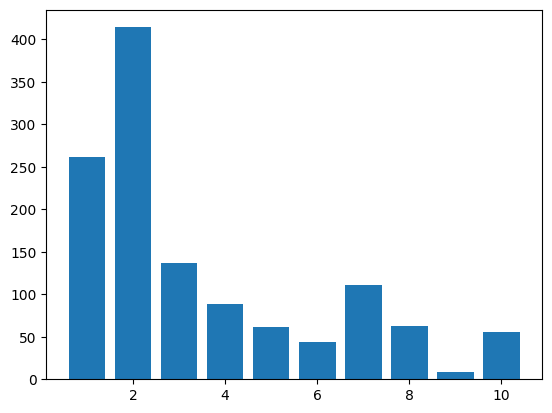

In [18]:
# Plot analytic banlance dataset

totalLabelDataset = np.array([0] * 10)
for ele in labelDataset:
    totalLabelDataset += ele["label"]

print(totalLabelDataset)
    
# Draw
plt.bar([i for i in range(1, 11)], totalLabelDataset)

In [19]:
print(labelDataset[0])

{'name': 'G93aRj07CIZPKaC8.jpg', 'label': array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0]), 'total': 16}


In [26]:
csvDataJSON = []
listGoodImage = []
labelValue = ["Hồ Gươm", "Hồ Tây", "Tháp rùa", "Cầu Thê Húc", "Bưu Điện", "Vườn Hoa", "Chùa Trấn Quốc", "Đền Quán Thánh", "Khách Sạn", "Công Viên Nước"]
for ele in labelDataset:
    labelTemp = {}
    for i in range(len(labelValue)):
        labelTemp[labelValue[i]] = ele["label"][i]
    csvDataJSON.append({
        "file": ele["name"],
        **labelTemp
    })
    listGoodImage.append(ele["name"])

In [24]:
# Create csv file
import pandas as pd
pd.DataFrame(csvDataJSON).to_csv("labelData.csv", index=False)

In [27]:
# Create list good 
f = open("listimage.txt", "w")
f.write("\n".join(listGoodImage))
f.close()

In [ ]:
# Note:
# imagesDataset is an Dict key is name image, value is image data
# Using: get image data of label name N => imagesDataset[N]
# Get image data of label i => imagesDataset[labelDataset[i]["name"]]